## An Unsupervised Approach for Automatic Activity Recognition based on Hidden Markov Model Regression



## Exemple Gaussian HMM: one sequence

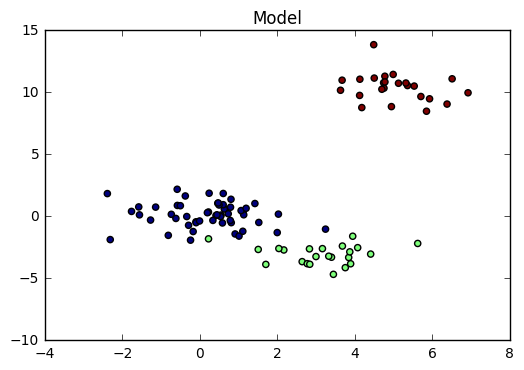

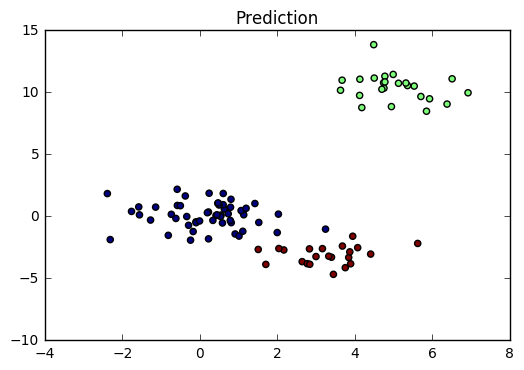

In [87]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
np.random.seed(42)

# Generating variables with known parameter distributions 
model = hmm.GaussianHMM(n_components=3, covariance_type="full")
model.startprob_ = np.array([0.6, 0.3, 0.1])
model.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.3, 0.3, 0.4]])
model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
model.covars_ = np.tile(np.identity(2), (3, 1, 1))
X, Z = model.sample(100)

plt.scatter(X[:,0],X[:,1], c=Z)
plt.title('Model')
plt.show()

# Learning parametres using the dataset
remodel = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100)
remodel.fit(X)  
Z2 = remodel.predict(X)
plt.scatter(X[:,0],X[:,1], c=Z2)
plt.title('Prediction')
plt.show()

## Exemple Gaussian MHMM: multiple sequences

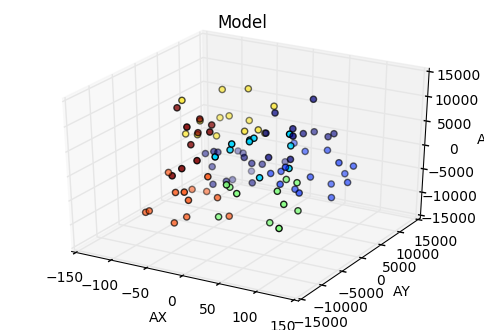

C:\Users\KAIS\Anaconda3\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\KAIS\Anaconda3\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\KAIS\Anaconda3\lib\site-packages\hmmlearn\base.py:451: RuntimeWarning: divide by zero encountered in log
  n_samples, n_components, np.log(self.startprob_),


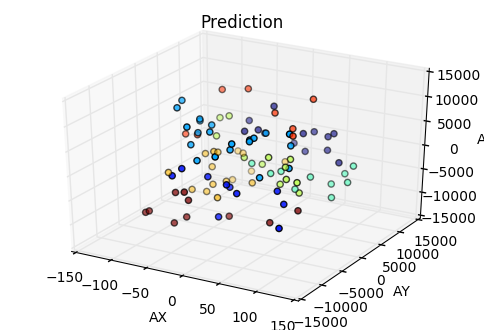

In [127]:
import numpy as np
import random
from hmmlearn import hmm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(42)

# Generating random variables
# Time
T=[i for i in range(100)]
# Accelertaion X
X=[random.uniform(-100,100) for i in range(100)]
AX=np.array(X)

# Acceleration Y
Y=[100*random.uniform(-100,100) for i in range(100)]
AY=np.array(Y)

# Acceleration Z
Z=[100*random.uniform(-100,100) for i in range(100)]        
AZ=np.array(Z)

# Activités: 8 types
A=[0 for i in range(100)]
for i in range(100):
    if (X[i] > 0) & (Y[i] > 0) & (Z[i] > 0):
        A[i]=0
    elif (X[i] > 0) & (Y[i] > 0) & (Z[i] < 0):
        A[i]=1
    elif (X[i] > 0) & (Y[i] < 0) & (Z[i] > 0):
        A[i]=2
    elif (X[i] > 0) & (Y[i] < 0) & (Z[i] < 0):
        A[i]=3
    elif (X[i] < 0) & (Y[i] > 0) & (Z[i] > 0):
        A[i]=4
    elif (X[i] < 0) & (Y[i] < 0) & (Z[i] < 0):
        A[i]=5
    elif (X[i] < 0) & (Y[i] < 0) & (Z[i] > 0):
        A[i]=6
    elif (X[i] < 0) & (Y[i] < 0) & (Z[i] < 0):
        A[i]=7      
AA=np.array(A) 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(AX, AY, AZ,c=AA)
plt.title('Model')
ax.set_xlabel('AX')
ax.set_ylabel('AY')
ax.set_zlabel('AZ')
plt.show()

# Learning parametres using the dataset
remodel = hmm.GaussianHMM(n_components=8, covariance_type="full", n_iter=100000)
M=[[AX[i],AY[i],AZ[i]] for i in range(100)]
AM=np.array(M)
remodel.fit(AM)  
AA2 = remodel.predict(AM)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(AX, AY, AZ,c=AA2)
plt.title('Prediction')
ax.set_xlabel('AX')
ax.set_ylabel('AY')
ax.set_zlabel('AZ')
plt.show()


## Première essai sur notre DATA: l'homme 1

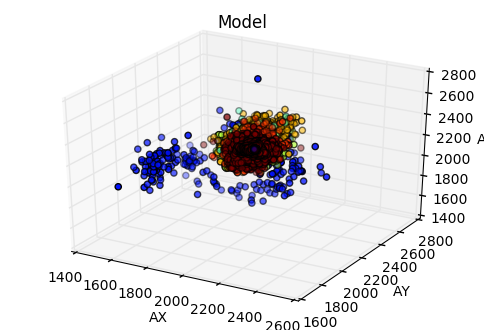

C:\Users\KAIS\Anaconda3\lib\site-packages\hmmlearn\base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\KAIS\Anaconda3\lib\site-packages\hmmlearn\base.py:468: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
C:\Users\KAIS\Anaconda3\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\KAIS\Anaconda3\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\KAIS\Anaconda3\lib\site-packages\hmmlearn\base.py:624: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\KAIS\Anaconda3\lib\site-packages\hmmlearn\base.py:451: RuntimeWarning: divide by zero encountered in log
  n_samples, n_components, np.log(self.startprob_),
C:\Users\KAIS\Anaconda3\lib\site-packages\hmmlearn\base.py:452: RuntimeWarning: divide by zero encountered in log
  np.log(self.tran

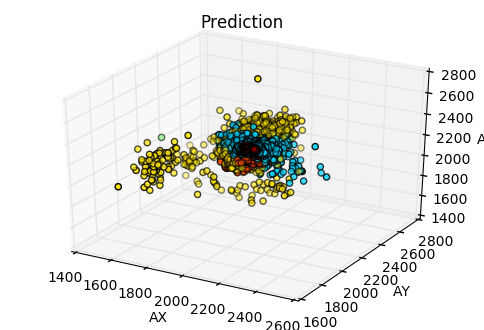

In [140]:
import numpy as np
import random
from hmmlearn import hmm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(42)

# Uploadinf the data
DATA = np.genfromtxt('1.csv', delimiter = ',')
# Size
L=len(DATA[:,0])
# Time
T=DATA[:,0]
# Acceleration X
AX=DATA[:,1]
# Acceleration Y
AY=DATA[:,2]
# Acceleration Z
AZ=DATA[:,3]
# Acivities: 7 types
AA=DATA[:,4]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(AX, AY, AZ,c=AA)
plt.title('Model')
ax.set_xlabel('AX')
ax.set_ylabel('AY')
ax.set_zlabel('AZ')
plt.show()


# Learning parametres using the dataset
remodel = hmm.GaussianHMM(n_components=7, covariance_type="full", n_iter=100000)
M=[[AX[i],AY[i],AZ[i]] for i in range(L)]
AM=np.array(M)
remodel.fit(AM)  
AA2 = remodel.predict(AM)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(AX, AY, AZ,c=AA2)
plt.title('Prediction')
ax.set_xlabel('AX')
ax.set_ylabel('AY')
ax.set_zlabel('AZ')
plt.show()
